In [32]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [3]:
dowhy.__version__

'0.11.1'

# Capítulo 07 - Modelos causais com DoWhy e EconML

Será utilizado o exemplo do capítulo 6 referente à relação entre uso de gps e diminuição de memória espacial

In [5]:
# structural causal model implementation to simulate relationship between variables
class GPSMemorySCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5) # A truncated normal continuous random variable.
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

0. Inicializar o modelo causal estrutural (SCM) gerando 1000 observações e armazenando-as em um dataframe

In [16]:
scm = GPSMemorySCM()
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])

In [17]:
df

,X,Z,Y
0,6.225679,-4.454288,-2.560397
1,4.616342,-2.961762,-1.517600
2,5.601022,-3.720484,-1.812550
3,1.956172,-0.798570,-0.277725
4,5.387576,-2.295802,-1.009667
...,...,...,...
995,7.218086,-4.682966,-3.086743
996,6.692651,-4.031849,-1.690158
997,10.693799,-6.832982,-3.199991
998,5.723100,-3.345406,-1.242973


## 1. Modelando o problema

### 1.1 definindo o grafo

In [18]:
# cria um grafo com GML

gml_graph = """ 
graph [
  directed 1

  node [
    id "X"
    label "X"
  ]
  node [
    id "Z"
    label "Z"
  ]
  node [
    id "Y"
    label "Y"
  ]
  node [
    id "U"
    label "U"
  ]
  
  edge [
    source "X"
    target "Z"
  ]

  edge [
    source "Z"
    target "Y"
  ]
  
  edge [
    source "U"
    target "X"
  ]
  
  edge [
    source "U"
    target "Y"
  ]

]
"""

### 1.2 definindo o modelo DoWhy

In [27]:
model = CausalModel(
  data = df,
  treatment = 'X',
  outcome = 'Y',
  graph = gml_graph
)

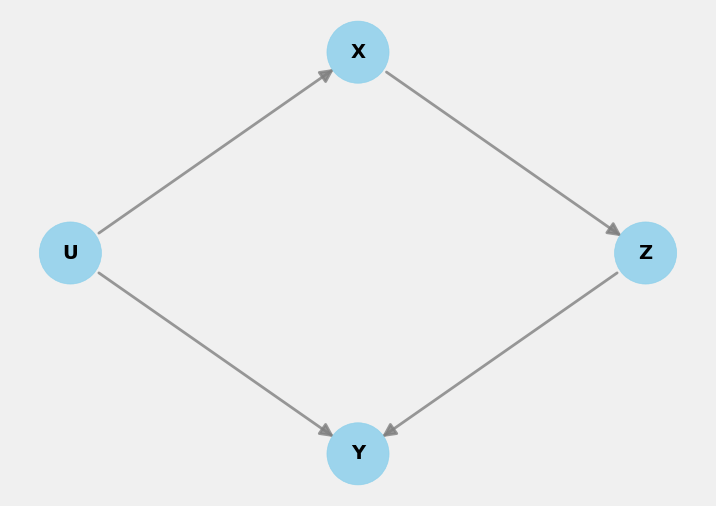

In [28]:
model.view_model()

## 2. Identificando os estimandos

In [29]:
estimand = model.identify_effect()

In [31]:
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



## 3. Obtendo estimativas

In [ ]:
estimate = model.estimate_effect(
  identified_estimand = estimand,
  method_name = 'frontdoor.two_stage_regression'
)

In [44]:
print(f"Estimate of causal effect (linear regression): {estimate.value}")

Estimate of causal effect (linear regression): -0.43586303679940325


## 4. Validando o modelo causal - refutation tests

In [ ]:
refute_subset = model.refute_estimate(
	estimand = estimand,
	estimate = estimate,
	method_name = 'data_subset_refuter',
	subset_fraction = 0.4
)

In [46]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.43586303679940325
New effect:-0.4353913768788903
p value:0.94

